<a href="https://colab.research.google.com/github/ProfAI/machine-learning-fondamenti/blob/main/Progetto%20Finale%20-%20Cross%20Selling%20di%20Polizze/health_insurance_cross_sell_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of Cross-Sell Opportunities for Insurance

This Jupyter Notebook contains a project aimed at predicting cross-sell opportunities for health insurance and it is structured as follows:

1. **Data Exploration**:
    - **Importing Data**: The dataset is imported and basic information about its structure and content is displayed.
    - **Correlation Analysis**: A correlation matrix is generated to understand relationships between different variables in the dataset. <br><br>
    
2. **Data Preprocessing**:
    - **Handling Missing Values**: Techniques to handle missing values in the dataset are applied.
    - **Feature Encoding**: Categorical variables are encoded using methods like label encoding and one-hot encoding.
    - **Data Normalization**: Features are normalized to ensure they contribute equally to the model's performance. <br><br>

3. **Model Training and Evaluation**:
    - **Model Selection**: Various machine learning models, such as logistic regression, decision trees and random forests, are trained on the dataset.
    - **Performance Metrics**: The performance of each model is evaluated using metrics such as accuracy, precision, recall, F1-score and ROC curve.
    - **Confusion Matrix**: Confusion matrices are plotted to visualize the performance of the models on both training and test sets. <br><br>

4. **Model Comparison**:
    - **Metrics Comparison**: The metrics of different models are compared to identify the best-performing model.
    - **ROC Curve Analysis**: ROC curves are plotted for the models to analyze their trade-offs between sensitivity and specificity. <br><br>

5. **Conclusions**:
    - **Final Model Performance**: The refined final model's performance is summarized, highlighting its potential in predicting interested customers with a balance between false positives and false negatives. <br><br>

This notebook provides a comprehensive approach to predicting cross-sell opportunities in the insurance sector, utilizing various machine learning techniques and thorough data analysis.

## Client Overview

The client is an insurance company that has provided health insurance to its customers and wants to build a predictive model to determine whether last year’s policyholders might also be interested in purchasing vehicle insurance.

## Dataset Properties

The dataset contains the following properties:

- **id**: Unique ID of the buyer.
- **Gender**: Gender of the buyer.
- **Age**: Age of the buyer.
- **Driving_License**: 1 if the user has a driver's license, 0 otherwise.
- **Region_Code**: Unique code of the buyer's region.
- **Previously_Insured**: 1 if the user already has a vehicle insured, 0 otherwise.
- **Vehicle_Age**: Age of the vehicle.
- **Vehicle_Damage**: 1 if the user has damaged the vehicle in the past, 0 otherwise.
- **Annual_Premium**: The amount the user has to pay as a premium during the year.
- **Policy_Sales_Channel**: Anonymized code of the channel used for the proposal (e.g., email, phone, in person, etc.).
- **Vintage**: Number of days the user has been a customer of the company.
- **Response**: 1 if the buyer has responded positively to the sales proposal, 0 otherwise.

## Objective

The goal of the model is to predict the value of **Response**.

## Dataset Link

[Link to Kaggle dataset](https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction)


# Project - Health Insurance Cross-Sell Prediction

## Libraries

In [1]:
# Data
import pandas as pd
import numpy as np

# Plot
from matplotlib import pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay

## Constants

In [2]:
# Random seed for models reproducibility
RANDOM_SEED = 0

## Global Variables

In [3]:
# Table used to gather and compare the metrics for different models
metrics_index = ["Model", "Precision", "Recall", "Accuracy", "F1"]
df_metrics_train = pd.DataFrame(columns = metrics_index)
df_metrics_test = pd.DataFrame(columns = metrics_index)

## Functions

In [4]:
def plot_confusion_matrix(y_true, y_pred, display_metrics = False, labels = ["Negative", "Positive"]):
    """
    Plot confusion matrix using real and predicted target values from a classification model.
    Optionally display the related precision, recall and accuracy metrics.
    """
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    #    0   1
    # 0 TN  FP
    # 1 FN  TP
    
    # Conversion of confusion matrix to dataframe
    df_cm = pd.DataFrame(cm, index = labels, columns = ["Predicted " + labels[0], "Predicted " + labels[1]])
    
    # Heatmap generation
    sns.heatmap(df_cm, annot = True, fmt = "g") # fmt = "g" -> no scientific notation
    
    # Display metrics in the plot
    if display_metrics:
        plt.text(0, -0.1, f"Precision: {cm[1, 1]/(cm[1, 1] + cm[0, 1]):.3f}")   # TP/(TP + FP)
        plt.text(1, -0.1, f"Recall: {cm[1, 1]/(cm[1, 1] + cm[1, 0]):.3f}")      # TP/(TP + FN)
        plt.text(1.9, -0.1, f"Accuracy: {(cm[0, 0] + cm[1,1])/np.sum(cm):.3f}") # (TP + TN)/(TP + FP + TN + FN)
    
    # Display heatmap
    plt.show()
    

        
def model_metrics(y_true, y_pred):
    """
    Receive real and predicted target values from a classification model and
    return the related precision, recall, accuracy, precision and F1 score metrics.
    """
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Metrics evaluation
    precision = cm[1, 1]/(cm[1, 1] + cm[0, 1])
    recall = cm[1, 1]/(cm[1, 1] + cm[1, 0])
    accuracy = (cm[0, 0] + cm[1,1])/np.sum(cm)
    f1 = 2*(precision*recall)/(precision + recall)
    
    return [precision, recall, accuracy, f1]



def create_logistic_regressor_and_show_metrics(X, y, test_size,
                                               
                                               # LogisticRegression parameters
                                               class_weight = None,
                                               regularization = None,
                                               
                                               # Under-Over sampler parameters
                                               sampler = None,
                                               sampling_strategy = None,
                                               
                                               # Random seed for reproducibility
                                               random_state = None,
                                               
                                               # Model name to allow metrics storage
                                               model_name = '', 
                                               
                                               # Metrics display option
                                               show_metrics = True,
                                               show_confusion_matrix = True):
    
    """
    Create a logistic regressor model receiving features, target and test size for hold out validation split.
    Allow to set the main hyperparameters and optionally show the metrics summary for train and test sets.
    If model name is provided, the metrics are stored in global dataframe variable.
    
    Return the fitted model.
    """
    
    # Declare global metrics dataframes
    global df_metrics_train, df_metrics_test

    # Split the data in train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state)
    
    # Standardization
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)
    
    # Undersampling
    if sampler == "RandomUnderSampler" and sampling_strategy != '':
        rus = RandomUnderSampler(sampling_strategy = sampling_strategy, random_state = RANDOM_SEED)
        X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
    
    # Oversampling
    if sampler == "RandomOverSampler" and sampling_strategy != '':
        ros = RandomOverSampler(sampling_strategy = sampling_strategy, random_state = RANDOM_SEED)
        X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
        
    # Regolarization
    if regularization != None:   
        penalty = regularization
        if regularization == "l1":
            solver = "liblinear"
            np.random.seed(random_state) # to force liblinear to exploit random_state seed
        else:
            solver = "lbfgs" # default
    else:
        penalty = "l2"   # default
        solver = "lbfgs" # default

    # Logistic regression fitting
    lr = LogisticRegression(class_weight = class_weight, penalty = penalty, solver = solver)
    if sampler == None:
        lr.fit(X_train, y_train)
    else:
        lr.fit(X_resampled, y_resampled)

    ## Predictions
    # Class prediction and related probability for target based on train set
    y_pred_train = lr.predict(X_train)
    y_proba_train = lr.predict_proba(X_train)

    # Class prediction and related probability for target based on test set
    y_pred_test = lr.predict(X_test)
    y_proba_test = lr.predict_proba(X_test)

    # Metrics
    if show_metrics:
        print("\n# Train Set - Metrics #")
        print(classification_report(y_train, y_pred_train))
        print("\n# Test Set - Metrics #")
        print(classification_report(y_test, y_pred_test))
           
    # Confusion matrix
    if show_confusion_matrix:
        print("\n# Train Set - Confusion Matrix #")
        plot_confusion_matrix(y_train, y_pred_train, display_metrics = True)
        print("\n# Test Set - Confusion Matrix #")
        plot_confusion_matrix(y_test, y_pred_test, display_metrics = True)


    # Store the metrics
    if model_name != '':
        
        # Retrieve metrics lists
        metrics_model_train = model_metrics(y_train, y_pred_train)
        metrics_model_test = model_metrics(y_test, y_pred_test)
        
        # Prepend model name to lists
        metrics_model_train.insert(0, model_name)
        metrics_model_test.insert(0, model_name)
        
        # Create new dataframe row and append it to global metrics dataframes
        new_row = pd.DataFrame([metrics_model_train], columns = df_metrics_train.columns)
        df_metrics_train = pd.concat([df_metrics_train, new_row], ignore_index = True)      
        new_row = pd.DataFrame([metrics_model_test], columns = df_metrics_test.columns)
        df_metrics_test = pd.concat([df_metrics_test, new_row], ignore_index = True)
        
    return lr

## Data Exploration

In [5]:
# Import the dataset
df = pd.read_csv("insurance_cross_sell.csv")

In [6]:
# Check the beginning...
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [7]:
# ...and the end of the dataframe
df.tail()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
381104,381105,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,381106,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,381107,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,381108,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0
381108,381109,Male,46,1,29.0,0,1-2 Year,No,41777.0,26.0,237,0


In [8]:
# Show dataframe size, columns names and variables types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


#### Correlation Matrix

To gain insights into the relationships among features, especially with the target variable, the correlation matrix is evaluated

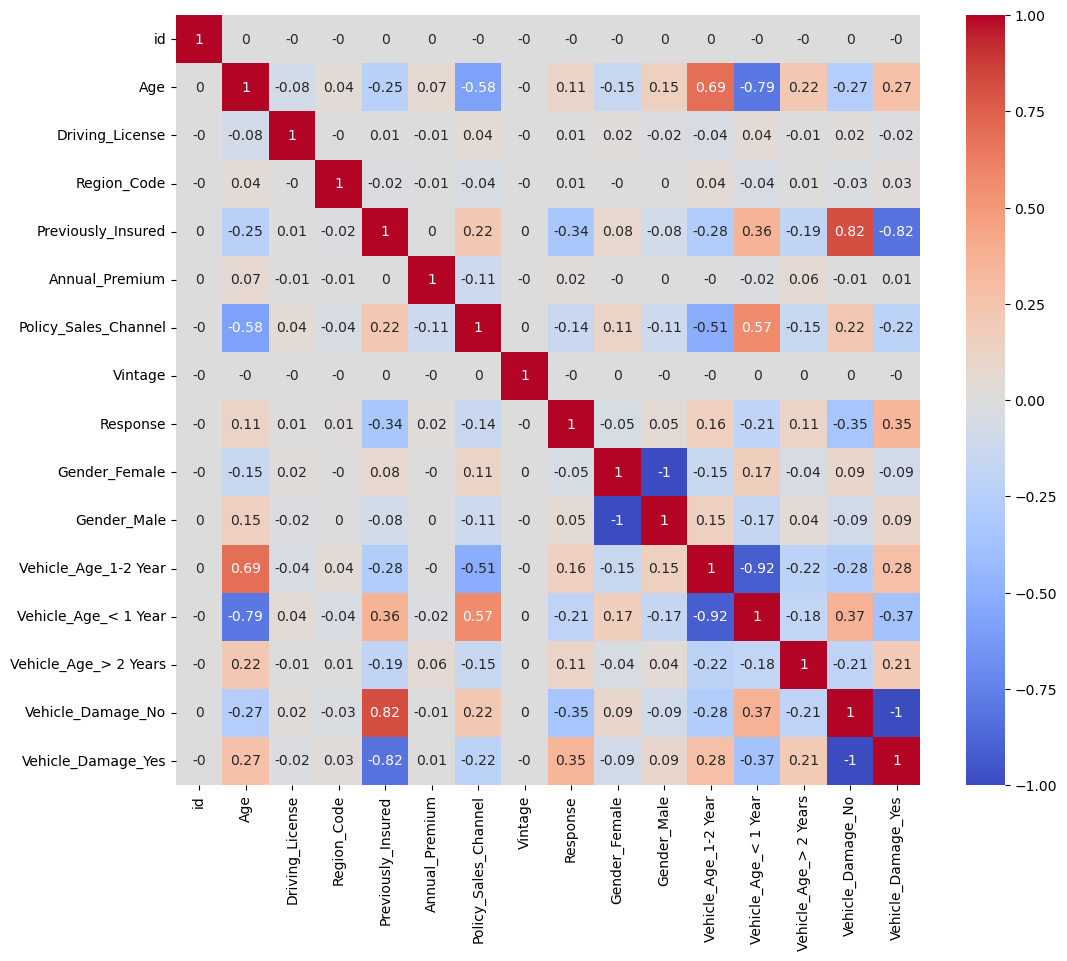

In [9]:
# Select categorical features
categorical_columns = df.select_dtypes(exclude = ["number"]).columns.tolist()

# Encode categorical features
df_corr = pd.get_dummies(df, columns = categorical_columns)

# Evaluate correlation
correlation_matrix = df_corr.corr(numeric_only = True)

# Plot correlation matrix
plt.figure(figsize = (12, 10))
sns.heatmap(round(correlation_matrix, 2), annot = True, cmap = "coolwarm")
plt.show()

The target variable "Response" seems weakly correlated with Age, Policy_Sales_Channel and Vehicle_Age, while shows a moderate correlation with Previously_Insured and Vehicle_Damage

## Preprocessing

In [10]:
# Preserve the original dataset
df_preproc = df.copy()

#### Removal of Unuseful Features

In [11]:
# Number of unique values
print("Number of unique values for each variable:")
for column in df_preproc.columns:
    print(f"- {column}: {len(df_preproc[column].unique())}")

Number of unique values for each variable:
- id: 381109
- Gender: 2
- Age: 66
- Driving_License: 2
- Region_Code: 53
- Previously_Insured: 2
- Vehicle_Age: 3
- Vehicle_Damage: 2
- Annual_Premium: 48838
- Policy_Sales_Channel: 155
- Vintage: 290
- Response: 2


Identifiers features such as "id" present singular occurrences within the dataset (unique values cardinality is equal to dataset rows number), offering limited or no informative value due to their unique and non-repetitive nature

In [12]:
# Remove "id" column
df_preproc.drop("id", axis = 1, inplace = True)

#### Missing Data Verification

In [13]:
# Sum of not available value for each column
df_preproc.isna().sum()

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

No missing values found in the dataset

#### Features Encoding - Binary and Ordinal

In [14]:
# Inspect categorical variables
df_preproc.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [15]:
# Check all unique different values for categorical features
non_numeric_columns = df_preproc.select_dtypes(exclude = ["number"]).columns.tolist()

print("# Unique values for categorical features #")
for column in non_numeric_columns:
    print(f"\n{column}:")
    value_counts = df_preproc[column].value_counts()
    for value, count in value_counts.items():
        print(f"- {value}: {count}")

# Unique values for categorical features #

Gender:
- Male: 206089
- Female: 175020

Vehicle_Age:
- 1-2 Year: 200316
- < 1 Year: 164786
- > 2 Years: 16007

Vehicle_Damage:
- Yes: 192413
- No: 188696


In [16]:
# Binary Encoding - Gender
mapping_gender = {
    "Male" : 0,
    "Female" : 1
}

df_preproc["Gender"] = df_preproc["Gender"].map(mapping_gender)
df_preproc.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,0,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,0,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,0,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,1,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [17]:
# Binary Encoding - Vehicle_Damage
mapping_vehicle_damage = {
    "No" : 0,
    "Yes" : 1
}

df_preproc["Vehicle_Damage"] = df_preproc["Vehicle_Damage"].map(mapping_vehicle_damage)
df_preproc.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,44,1,28.0,0,> 2 Years,1,40454.0,26.0,217,1
1,0,76,1,3.0,0,1-2 Year,0,33536.0,26.0,183,0
2,0,47,1,28.0,0,> 2 Years,1,38294.0,26.0,27,1
3,0,21,1,11.0,1,< 1 Year,0,28619.0,152.0,203,0
4,1,29,1,41.0,1,< 1 Year,0,27496.0,152.0,39,0


In [18]:
# Ordinal Encoding - Vehicle_Age
mapping_vehicle_age = {
    "< 1 Year" : 1,
    "1-2 Year" : 2,
    "> 2 Years" : 3
}

df_preproc["Vehicle_Age"] = df_preproc["Vehicle_Age"].map(mapping_vehicle_age)
df_preproc.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,44,1,28.0,0,3,1,40454.0,26.0,217,1
1,0,76,1,3.0,0,2,0,33536.0,26.0,183,0
2,0,47,1,28.0,0,3,1,38294.0,26.0,27,1
3,0,21,1,11.0,1,1,0,28619.0,152.0,203,0
4,1,29,1,41.0,1,1,0,27496.0,152.0,39,0


#### Features Encoding - One-Hot

 "Region_Code" and "Policy_Sales_Channel" features are expressed by numbers, but they actually represent qualitative variables

In [19]:
# Count the number of differents values
qualitative_feature = ["Region_Code", "Policy_Sales_Channel"]

print("Number of unique values for qualitative variables:")
for column in qualitative_feature:
    print(f"- {column}: {df_preproc[column].nunique()}")

Number of unique values for qualitative variables:
- Region_Code: 53
- Policy_Sales_Channel: 155


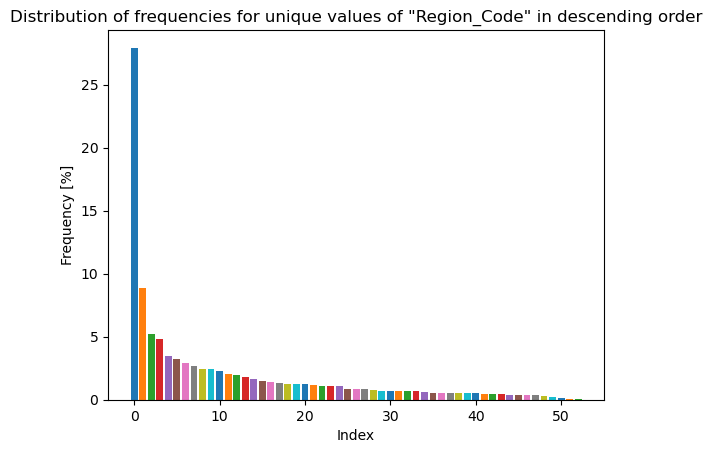

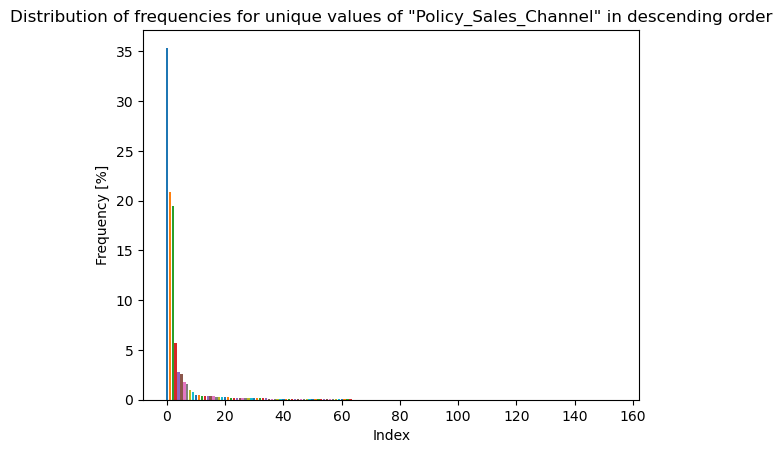

In [20]:
# Visualization of frequency distribution for unique values
for column in qualitative_feature:
    value_counts = df_preproc[column].value_counts(normalize = True, sort = True)

    index = 0
    for _, count in value_counts.items():
        plt.bar(index, 100*count)
        plt.title(f"Distribution of frequencies for unique values of \"{column}\" in descending order")
        plt.xlabel("Index")
        plt.ylabel("Frequency [%]")
        index += 1
    plt.show()

Since there are many modalities for both categorical features, applying one-hot encoding will generate an extensive set of new feature columns.
For optimization, it might be worth considering a later review of the process by splitting in classes and grouping the less frequent unique values together.
Additionally, due to the imbalanced classes, an enhancement of model performance may involve assigning greater weights to the less frequently represented classes.

In [21]:
# One-Hot Encoding - Region_Code
df_preproc = pd.get_dummies(df_preproc, columns = ["Region_Code"])
df_preproc.head()

,Gender,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,...,Region_Code_43.0,Region_Code_44.0,Region_Code_45.0,Region_Code_46.0,Region_Code_47.0,Region_Code_48.0,Region_Code_49.0,Region_Code_50.0,Region_Code_51.0,Region_Code_52.0
0,0,44,1,0,3,1,40454.0,26.0,217,1,...,False,False,False,False,False,False,False,False,False,False
1,0,76,1,0,2,0,33536.0,26.0,183,0,...,False,False,False,False,False,False,False,False,False,False
2,0,47,1,0,3,1,38294.0,26.0,27,1,...,False,False,False,False,False,False,False,False,False,False
3,0,21,1,1,1,0,28619.0,152.0,203,0,...,False,False,False,False,False,False,False,False,False,False
4,1,29,1,1,1,0,27496.0,152.0,39,0,...,False,False,False,False,False,False,False,False,False,False


In [22]:
# One-Hot Encoding - Policy_Sales_Channel
df_preproc = pd.get_dummies(df_preproc, columns = ["Policy_Sales_Channel"])
df_preproc.head()

,Gender,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Vintage,Response,Region_Code_0.0,...,Policy_Sales_Channel_152.0,Policy_Sales_Channel_153.0,Policy_Sales_Channel_154.0,Policy_Sales_Channel_155.0,Policy_Sales_Channel_156.0,Policy_Sales_Channel_157.0,Policy_Sales_Channel_158.0,Policy_Sales_Channel_159.0,Policy_Sales_Channel_160.0,Policy_Sales_Channel_163.0
0,0,44,1,0,3,1,40454.0,217,1,False,...,False,False,False,False,False,False,False,False,False,False
1,0,76,1,0,2,0,33536.0,183,0,False,...,False,False,False,False,False,False,False,False,False,False
2,0,47,1,0,3,1,38294.0,27,1,False,...,False,False,False,False,False,False,False,False,False,False
3,0,21,1,1,1,0,28619.0,203,0,False,...,True,False,False,False,False,False,False,False,False,False
4,1,29,1,1,1,0,27496.0,39,0,False,...,True,False,False,False,False,False,False,False,False,False


#### Features and Target Selection

In [23]:
# Select all features
X = df_preproc.copy()
X = X.drop("Response", axis = 1).values

# Select the target
y = df_preproc.copy()
y = y["Response"].values

## Model 1 - Hold-Out Validation - Baseline

As a first step, a baseline model is constructed using a simple logistic regression. This model is validated using a dataset split into a training and test set. The training set is utilized to train the model, while the test set is reserved to assess the model's performance on new data.


# Train Set - Metrics #
              precision    recall  f1-score   support

           0       0.88      1.00      0.93    234158
           1       0.38      0.00      0.00     32618

    accuracy                           0.88    266776
   macro avg       0.63      0.50      0.47    266776
weighted avg       0.82      0.88      0.82    266776


# Test Set - Metrics #
              precision    recall  f1-score   support

           0       0.88      1.00      0.93    100241
           1       0.27      0.00      0.00     14092

    accuracy                           0.88    114333
   macro avg       0.57      0.50      0.47    114333
weighted avg       0.80      0.88      0.82    114333


# Train Set - Confusion Matrix #


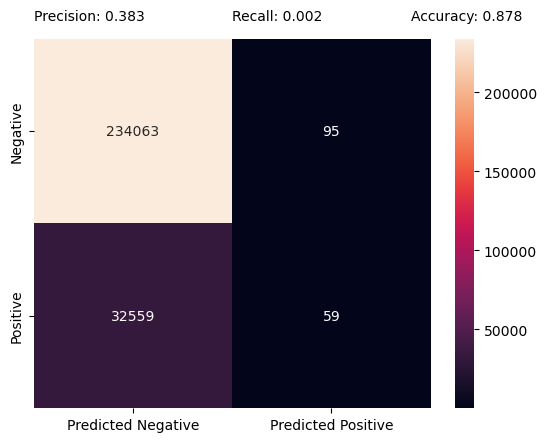


# Test Set - Confusion Matrix #


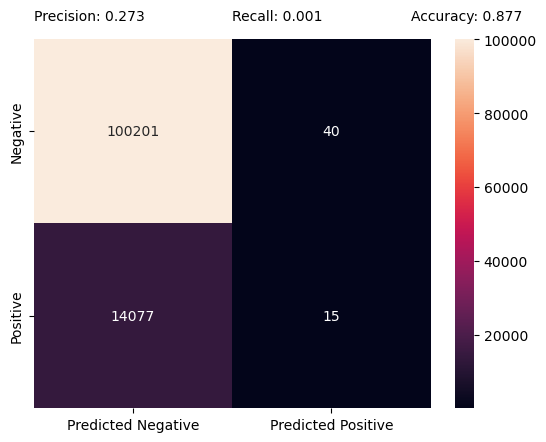

LogisticRegression()

In [24]:
create_logistic_regressor_and_show_metrics(X, y,
                                           test_size = 0.3,
                                           random_state = RANDOM_SEED,
                                           model_name = "M1_baseline",
                                           show_metrics = True,
                                           show_confusion_matrix = True)

## Model 2 - Hold-Out Validation with Class Balanced

Given the baseline model's notably poor recall, characterized by a substantial number of false negatives, an attempt to enhance performance involves implementing a logistic regression model with balanced class weights. Notably, certain features within the dataset present highly skewed distributions across their respective categories, resulting in less frequent classes being penalized.


# Train Set - Metrics #
              precision    recall  f1-score   support

           0       0.99      0.66      0.79    234158
           1       0.28      0.94      0.43     32618

    accuracy                           0.69    266776
   macro avg       0.63      0.80      0.61    266776
weighted avg       0.90      0.69      0.75    266776


# Test Set - Metrics #
              precision    recall  f1-score   support

           0       0.99      0.66      0.79    100241
           1       0.28      0.94      0.43     14092

    accuracy                           0.69    114333
   macro avg       0.63      0.80      0.61    114333
weighted avg       0.90      0.69      0.75    114333


# Train Set - Confusion Matrix #


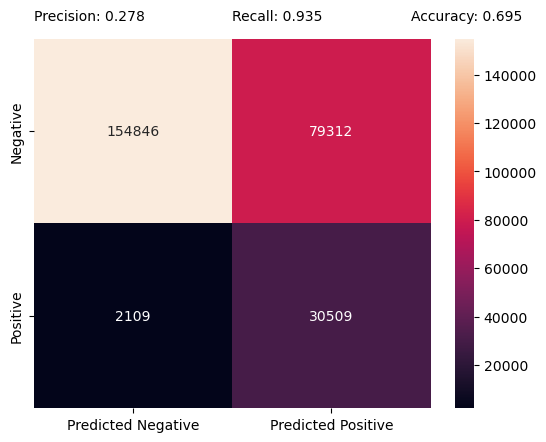


# Test Set - Confusion Matrix #


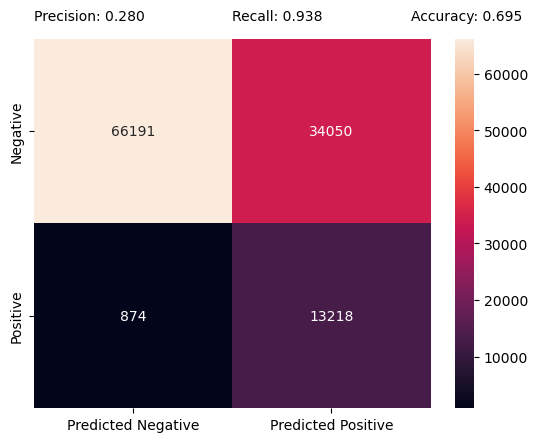

LogisticRegression(class_weight='balanced')

In [25]:
create_logistic_regressor_and_show_metrics(X, y,
                                           test_size = 0.3,
                                           class_weight = "balanced",
                                           random_state = RANDOM_SEED,
                                           model_name = "M2_class_balance",
                                           show_metrics = True,
                                           show_confusion_matrix = True)

## Model 3 - Hold-Out Validation with Undersampling Majority

By balancing the classes, the recall value shows a significant improvement, albeit at the expense of a decrease in accuracy. Subsequently a new model is trained by undersampling the most frequent class for each feature, aiming to maintain balanced weights across the dataset's different classes.


# Train Set - Metrics #
              precision    recall  f1-score   support

           0       0.99      0.66      0.79    234158
           1       0.28      0.93      0.43     32618

    accuracy                           0.70    266776
   macro avg       0.63      0.80      0.61    266776
weighted avg       0.90      0.70      0.75    266776


# Test Set - Metrics #
              precision    recall  f1-score   support

           0       0.99      0.66      0.79    100241
           1       0.28      0.94      0.43     14092

    accuracy                           0.69    114333
   macro avg       0.63      0.80      0.61    114333
weighted avg       0.90      0.69      0.75    114333


# Train Set - Confusion Matrix #


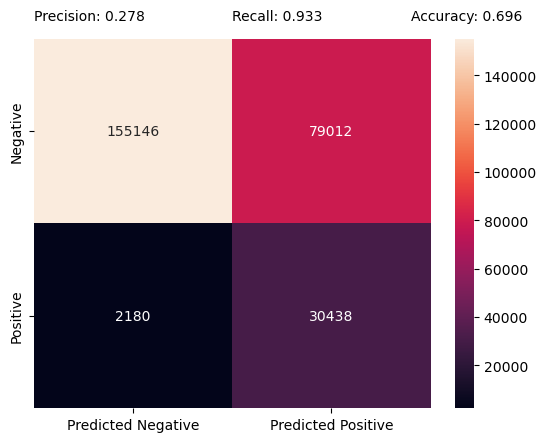


# Test Set - Confusion Matrix #


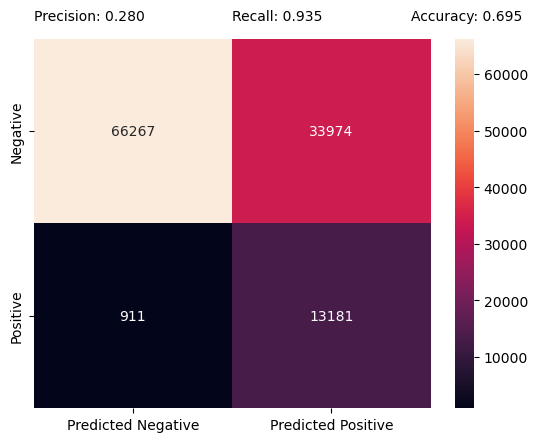

LogisticRegression()

In [26]:
create_logistic_regressor_and_show_metrics(X, y,
                                           test_size = 0.3,
                                           sampler = "RandomUnderSampler",
                                           sampling_strategy = "majority",
                                           random_state = RANDOM_SEED,
                                           model_name = "M3_under_major",
                                           show_metrics = True,
                                           show_confusion_matrix = True)

## Model 4 - Hold-Out Validation with Undersampling Not Minority

Following a similar approach, another model is trained by extending the undersampling technique to all classes except the minority class.


# Train Set - Metrics #
              precision    recall  f1-score   support

           0       0.99      0.66      0.79    234158
           1       0.28      0.93      0.43     32618

    accuracy                           0.70    266776
   macro avg       0.63      0.80      0.61    266776
weighted avg       0.90      0.70      0.75    266776


# Test Set - Metrics #
              precision    recall  f1-score   support

           0       0.99      0.66      0.79    100241
           1       0.28      0.94      0.43     14092

    accuracy                           0.69    114333
   macro avg       0.63      0.80      0.61    114333
weighted avg       0.90      0.69      0.75    114333


# Train Set - Confusion Matrix #


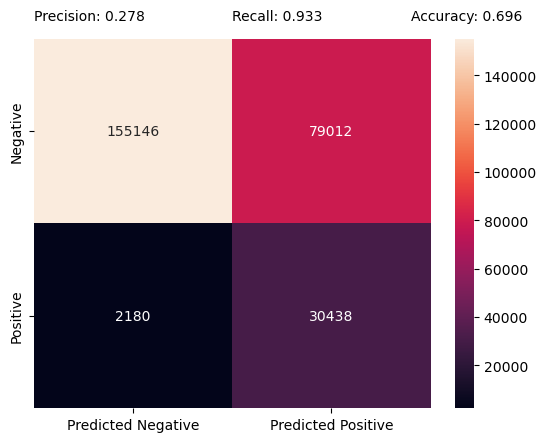


# Test Set - Confusion Matrix #


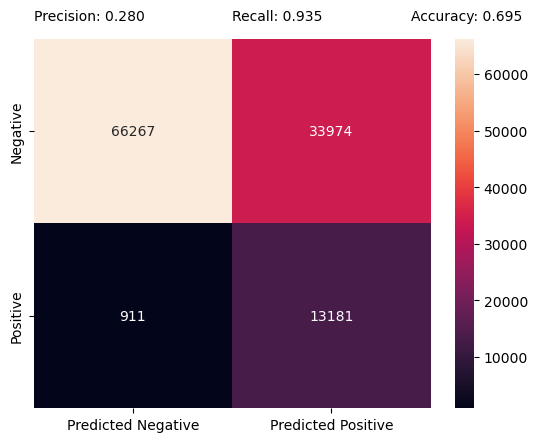

LogisticRegression()

In [27]:
create_logistic_regressor_and_show_metrics(X, y,
                                           test_size = 0.3,
                                           sampler = "RandomUnderSampler",
                                           sampling_strategy = "not minority",
                                           random_state = RANDOM_SEED,
                                           model_name = "M4_under_auto",
                                           show_metrics = True,
                                           show_confusion_matrix = True)

## Model 5 - Hold-Out Validation with Oversampling Not Majority

Utilizing a complementary methodology, a model is created by oversampling all the less frequent classes, excluding the majority class.


# Train Set - Metrics #
              precision    recall  f1-score   support

           0       0.99      0.66      0.79    234158
           1       0.28      0.93      0.43     32618

    accuracy                           0.70    266776
   macro avg       0.63      0.80      0.61    266776
weighted avg       0.90      0.70      0.75    266776


# Test Set - Metrics #
              precision    recall  f1-score   support

           0       0.99      0.66      0.79    100241
           1       0.28      0.94      0.43     14092

    accuracy                           0.70    114333
   macro avg       0.63      0.80      0.61    114333
weighted avg       0.90      0.70      0.75    114333


# Train Set - Confusion Matrix #


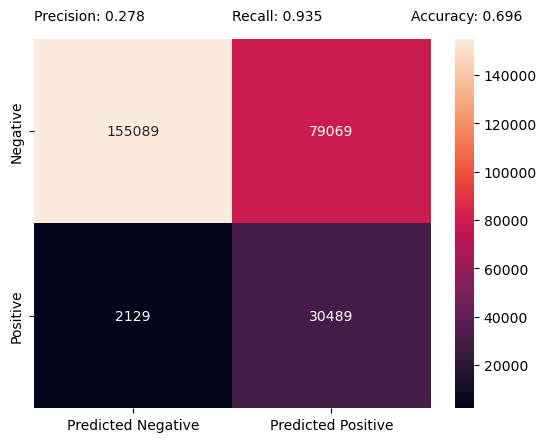


# Test Set - Confusion Matrix #


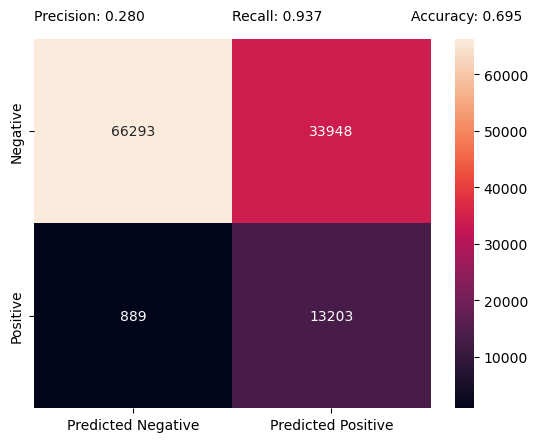

LogisticRegression()

In [28]:
create_logistic_regressor_and_show_metrics(X, y,
                                           test_size = 0.3,
                                           sampler = "RandomOverSampler",
                                           sampling_strategy = "not majority",
                                           random_state = RANDOM_SEED,
                                           model_name = "M5_over_auto",
                                           show_metrics = True,
                                           show_confusion_matrix = True)

## Models Comparison

In [29]:
print("Train Models - Metrics Comparison")
round(df_metrics_train, 2)

Train Models - Metrics Comparison


,Model,Precision,Recall,Accuracy,F1
0,M1_baseline,0.38,0.00,0.88,0.00
1,M2_class_balance,0.28,0.94,0.69,0.43
2,M3_under_major,0.28,0.93,0.70,0.43
3,M4_under_auto,0.28,0.93,0.70,0.43
4,M5_over_auto,0.28,0.93,0.70,0.43


In [30]:
print("Train Models - Metrics Comparison")
round(df_metrics_test, 2)

Train Models - Metrics Comparison


,Model,Precision,Recall,Accuracy,F1
0,M1_baseline,0.27,0.00,0.88,0.00
1,M2_class_balance,0.28,0.94,0.69,0.43
2,M3_under_major,0.28,0.94,0.69,0.43
3,M4_under_auto,0.28,0.94,0.69,0.43
4,M5_over_auto,0.28,0.94,0.70,0.43


All models utilizing class balancing, undersampling and oversampling exhibit similar performance metrics.

## Model 5.1 - Hold-Out Validation with Oversampling Not Majority and Lasso Regularization

For the last Model 5, it will be applied Ridge and Lasso regularizations to assess if further enhancements in performance can be achieved.


# Train Set - Metrics #
              precision    recall  f1-score   support

           0       0.99      0.66      0.79    234158
           1       0.28      0.93      0.43     32618

    accuracy                           0.70    266776
   macro avg       0.63      0.80      0.61    266776
weighted avg       0.90      0.70      0.75    266776


# Test Set - Metrics #
              precision    recall  f1-score   support

           0       0.99      0.66      0.79    100241
           1       0.28      0.94      0.43     14092

    accuracy                           0.70    114333
   macro avg       0.63      0.80      0.61    114333
weighted avg       0.90      0.70      0.75    114333


# Train Set - Confusion Matrix #


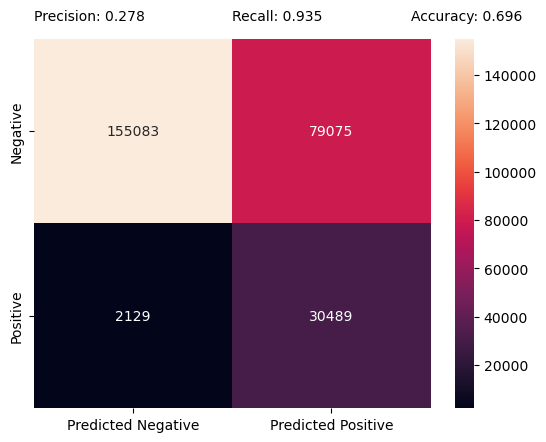


# Test Set - Confusion Matrix #


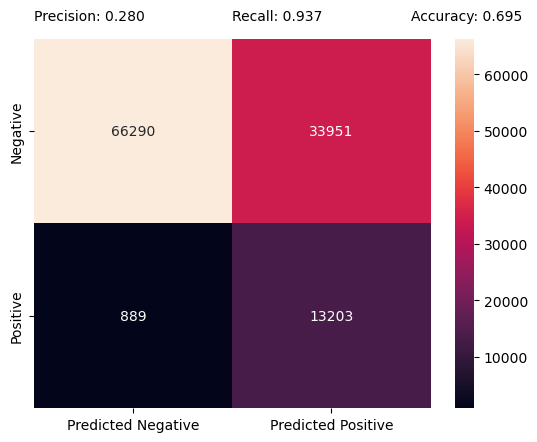

LogisticRegression(penalty='l1', solver='liblinear')

In [31]:
create_logistic_regressor_and_show_metrics(X, y,
                                           test_size = 0.3,
                                           regularization = "l1",
                                           sampler = "RandomOverSampler",
                                           sampling_strategy = "not majority",
                                           random_state = RANDOM_SEED,
                                           model_name = "M5_1_over_L1",
                                           show_metrics = True,
                                           show_confusion_matrix = True)

## Model 5.2 - Hold-Out Validation with Oversampling Not Majority and Ridge Regularization


# Train Set - Metrics #
              precision    recall  f1-score   support

           0       0.99      0.66      0.79    234158
           1       0.28      0.93      0.43     32618

    accuracy                           0.70    266776
   macro avg       0.63      0.80      0.61    266776
weighted avg       0.90      0.70      0.75    266776


# Test Set - Metrics #
              precision    recall  f1-score   support

           0       0.99      0.66      0.79    100241
           1       0.28      0.94      0.43     14092

    accuracy                           0.70    114333
   macro avg       0.63      0.80      0.61    114333
weighted avg       0.90      0.70      0.75    114333


# Train Set - Confusion Matrix #


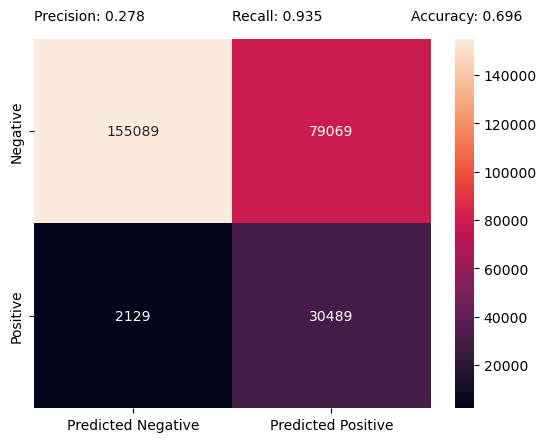


# Test Set - Confusion Matrix #


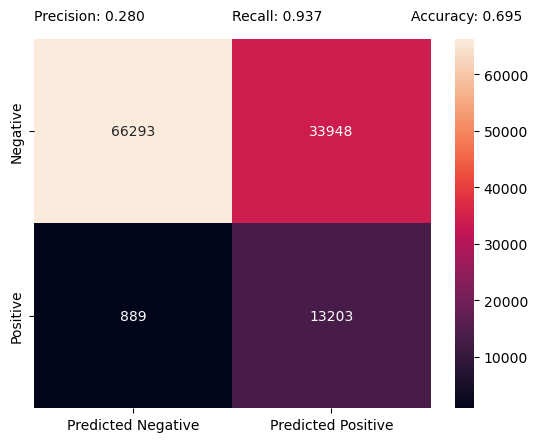

LogisticRegression()

In [32]:
create_logistic_regressor_and_show_metrics(X, y,
                                           test_size = 0.3,
                                           regularization = "l2",
                                           sampler = "RandomOverSampler",
                                           sampling_strategy = "not majority",
                                           random_state = RANDOM_SEED,
                                           model_name = "M5_2_over_L2",
                                           show_metrics = True,
                                           show_confusion_matrix = True)

## Models Comparison

In [33]:
print("Train Models - Metrics Comparison")
round(df_metrics_train, 2)

Train Models - Metrics Comparison


,Model,Precision,Recall,Accuracy,F1
0,M1_baseline,0.38,0.00,0.88,0.00
1,M2_class_balance,0.28,0.94,0.69,0.43
2,M3_under_major,0.28,0.93,0.70,0.43
3,M4_under_auto,0.28,0.93,0.70,0.43
4,M5_over_auto,0.28,0.93,0.70,0.43
5,M5_1_over_L1,0.28,0.93,0.70,0.43
6,M5_2_over_L2,0.28,0.93,0.70,0.43


In [34]:
print("Train Models - Metrics Comparison")
round(df_metrics_test, 2)

Train Models - Metrics Comparison


,Model,Precision,Recall,Accuracy,F1
0,M1_baseline,0.27,0.00,0.88,0.00
1,M2_class_balance,0.28,0.94,0.69,0.43
2,M3_under_major,0.28,0.94,0.69,0.43
3,M4_under_auto,0.28,0.94,0.69,0.43
4,M5_over_auto,0.28,0.94,0.70,0.43
5,M5_1_over_L1,0.28,0.94,0.70,0.43
6,M5_2_over_L2,0.28,0.94,0.70,0.43


Despite applying L1 and L2 regularizations, there were no significant improvements observed in the model. It seems that the model has reached its optimal point, within the bounds of the techniques applied so far

## Model Enhancement - Recall = 1

The model aims to predict whether someone with health insurance might also be interested in purchasing vehicle insurance. Supposing that acquiring new customers yields more benefits compared to resources spent on contacting an eventually uninterested individual, it is preferable to minimize false negatives (potential new customers incorrectly predicted as uninterested) to maximize the chances of gaining new policyholders. Regenerating in full the last Model 5.2, by refining the activation function threshold, predictions can be enhanced for this purposes. This involves lowering the threshold for predicting a positive response to increase the recall value close to 1.

In [35]:
# Split the data in 70% train and 30% test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = RANDOM_SEED)

# Standardization
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

# Oversampling
rus = RandomOverSampler(sampling_strategy = "not majority", random_state = RANDOM_SEED)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
        
# Logistic regression fitting
lr = LogisticRegression(penalty = "l2")
lr.fit(X_resampled, y_resampled)

# Class prediction and related probability for "Response" based on train set
y_pred_train = lr.predict(X_train)
y_proba_train = lr.predict_proba(X_train)

# Class prediction and related probability for "Response" based on test set
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)
y_proba_test = lr.predict_proba(X_test)

The threshold of the activation function is iteratively decreased until the recall reaches a value close to 1

In [36]:
# Threshold final value
threshold = 0.1

# If the likelyhood for class "1" (positive response) is higher than threshold, set the prediction to "1", "0" otherwise
y_pred_train = np.where(y_proba_train[:, 1] > threshold, 1, 0)
y_pred_test = np.where(y_proba_test[:, 1] > threshold, 1, 0)

In [37]:
# Metrics for train set
print(classification_report(y_train, y_pred_train))
metrics_model5_2_enhanced_train = model_metrics(y_train, y_pred_train)

              precision    recall  f1-score   support

           0       1.00      0.53      0.69    234158
           1       0.23      1.00      0.37     32618

    accuracy                           0.59    266776
   macro avg       0.61      0.76      0.53    266776
weighted avg       0.90      0.59      0.66    266776



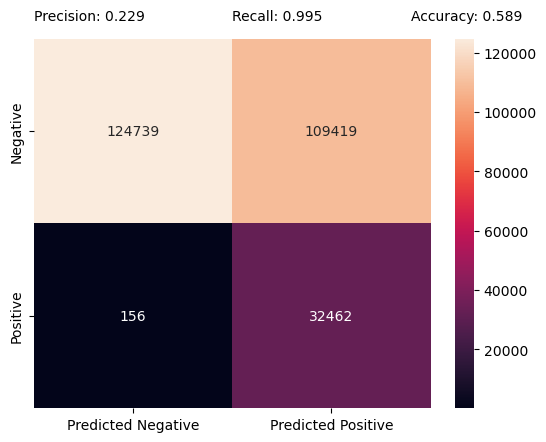

In [38]:
# Confusion matrix for train set
plot_confusion_matrix(y_train, y_pred_train, display_metrics = True)

In [39]:
# Metrics for test set
print(classification_report(y_test, y_pred_test))
metrics_model5_2_enhanced_test = model_metrics(y_test, y_pred_test)

              precision    recall  f1-score   support

           0       1.00      0.53      0.69    100241
           1       0.23      1.00      0.37     14092

    accuracy                           0.59    114333
   macro avg       0.61      0.76      0.53    114333
weighted avg       0.90      0.59      0.65    114333



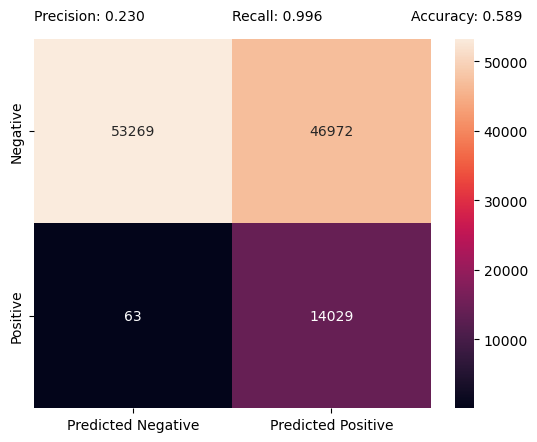

In [40]:
# Confusion matrix for test set
plot_confusion_matrix(y_test, y_pred_test, display_metrics = True)

In [41]:
# Store the metrics
model_name = "M5_2_enhanced"
metrics_model5_2_enhanced_train.insert(0, model_name)
metrics_model5_2_enhanced_test.insert(0, model_name)

new_row = pd.DataFrame([metrics_model5_2_enhanced_train], columns = df_metrics_train.columns)
df_metrics_train = pd.concat([df_metrics_train, new_row], ignore_index = True)
new_row = pd.DataFrame([metrics_model5_2_enhanced_test], columns = df_metrics_test.columns)
df_metrics_test = pd.concat([df_metrics_test, new_row], ignore_index = True)

## Models Comparison

In [42]:
print("Train Models - Metrics Comparison")
round(df_metrics_train, 2)

Train Models - Metrics Comparison


,Model,Precision,Recall,Accuracy,F1
0,M1_baseline,0.38,0.00,0.88,0.00
1,M2_class_balance,0.28,0.94,0.69,0.43
2,M3_under_major,0.28,0.93,0.70,0.43
3,M4_under_auto,0.28,0.93,0.70,0.43
4,M5_over_auto,0.28,0.93,0.70,0.43
5,M5_1_over_L1,0.28,0.93,0.70,0.43
6,M5_2_over_L2,0.28,0.93,0.70,0.43
7,M5_2_enhanced,0.23,1.00,0.59,0.37


In [43]:
print("Train Models - Metrics Comparison")
round(df_metrics_test, 2)

Train Models - Metrics Comparison


,Model,Precision,Recall,Accuracy,F1
0,M1_baseline,0.27,0.00,0.88,0.00
1,M2_class_balance,0.28,0.94,0.69,0.43
2,M3_under_major,0.28,0.94,0.69,0.43
3,M4_under_auto,0.28,0.94,0.69,0.43
4,M5_over_auto,0.28,0.94,0.70,0.43
5,M5_1_over_L1,0.28,0.94,0.70,0.43
6,M5_2_over_L2,0.28,0.94,0.70,0.43
7,M5_2_enhanced,0.23,1.00,0.59,0.37


## ROC Curve

The ROC curve shows how the trade-off between sensitivity and specificity changes as the threshold of the model's activation function varies

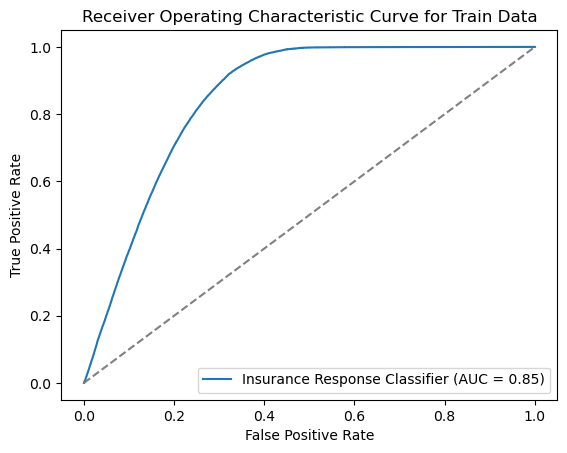

In [44]:
# ROC curve visualization for train data
RocCurveDisplay.from_estimator(lr, X_train, y_train, name = "Insurance Response Classifier")
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'grey', label = 'Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve for Train Data')
plt.show()

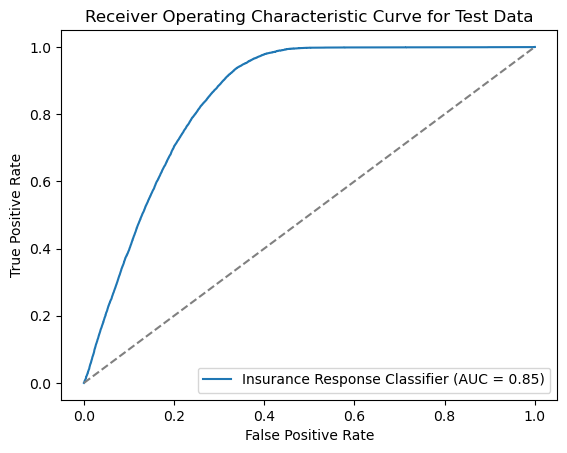

In [45]:
# ROC curve visualization for test data
RocCurveDisplay.from_estimator(lr, X_test, y_test, name = "Insurance Response Classifier")
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'grey', label = 'Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve for Test Data')
plt.show()

## Conclusions

The refined final model demonstrates good potential in predicting potential interested customers, excluding relatively few false negatives. However it generally exhibits a rather low precision, evidenced by a quantity of false positives almost comparable to correctly predicted true negatives. This effect was amplified by setting the activation threshold to a very low value to boost the recall, but at the expense of accuracy. If the presence of many false negatives is wasteful in terms of business resources, further enhancement of the model is considered necessary by applying more advanced modeling techniques.